<a href="https://colab.research.google.com/github/san9roy/Space-Telemetry-for-LEO-Satellites/blob/main/LEO_TELEMETRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""
Satellite Telemetry Data Analysis (Synthetic, Physics-Inspired)

Perspective:
- The goal is to generate *synthetic but realistic-looking* satellite housekeeping telemetry for analysis,
  while keeping the models simple enough to understand, justify, and extend in an MSc Space Science context.

What this script does:
1) Simulates a LEO spacecraft with ~90 min orbit and eclipse cycles (sunlit vs eclipse).
2) Generates telemetry channels with physically motivated dynamics:
   - Power: Li-ion pack SoC/OCV + internal resistance + charge/discharge in eclipse/sunlight
   - Thermal: first-order thermal system driven by environment + dissipated power
   - Comms: contact windows (in-view) + link-quality (dB proxy) + packet success/dropouts during contact
3) Injects fault scenarios with ground-truth labels (label_gt):
   - Increased internal resistance (voltage sag under load)
   - Heater stuck ON (thermal anomaly)
   - RF degradation during a pass (link-quality anomaly)
   - Random sensor glitches (spikes)
4) Adds measurement noise and packet loss (only during contact).
5) Filters signals (median + simple 1D Kalman smoother).
6) Detects anomalies:
   - Rule-based (engineering thresholds + jump detectors)
   - IsolationForest (ML baseline)
7) Evaluates detectors vs injected ground truth (optionally only during contact).

Outputs:
- synthetic_satellite_telemetry.csv
- Diagnostic plots
"""

'\nSatellite Telemetry Data Analysis (Synthetic, Physics-Inspired)\n\nPerspective:\n- The goal is to generate *synthetic but realistic-looking* satellite housekeeping telemetry for analysis,\n  while keeping the models simple enough to understand, justify, and extend in an MSc Space Science context.\n\nWhat this script does:\n1) Simulates a LEO spacecraft with ~90 min orbit and eclipse cycles (sunlit vs eclipse).\n2) Generates telemetry channels with physically motivated dynamics:\n   - Power: Li-ion pack SoC/OCV + internal resistance + charge/discharge in eclipse/sunlight\n   - Thermal: first-order thermal system driven by environment + dissipated power\n   - Comms: contact windows (in-view) + link-quality (dB proxy) + packet success/dropouts during contact\n3) Injects fault scenarios with ground-truth labels (label_gt):\n   - Increased internal resistance (voltage sag under load)\n   - Heater stuck ON (thermal anomaly)\n   - RF degradation during a pass (link-quality anomaly)\n   - R

In [4]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
# ------------------------------------------------------------
# Utility helpers
# ------------------------------------------------------------
def clamp(x: np.ndarray, lo: float, hi: float) -> np.ndarray:
    return np.minimum(np.maximum(x, lo), hi)


def rolling_median(s: pd.Series, w: int) -> pd.Series:
    """Robust pre-filter to suppress spikes before smoother/ML."""
    return s.rolling(w, center=True, min_periods=1).median()


def kalman_1d_smoother(z: np.ndarray, q: float, r: float) -> np.ndarray:
    """
    Simple 1D Kalman filter for smoothing a noisy time series.
    Model: random walk state
        x_k = x_{k-1} + w,  w~N(0,q)
        z_k = x_k + v,      v~N(0,r)

    q: process noise variance (higher => less smooth, tracks changes faster)
    r: measurement noise variance (higher => smoother, trusts measurements less)
    """
    x = np.zeros_like(z, dtype=float)
    p = 1.0
    x[0] = z[0]

    for k in range(1, len(z)):
        # Predict
        x_pred = x[k - 1]
        p_pred = p + q

        # Update
        k_gain = p_pred / (p_pred + r)
        x[k] = x_pred + k_gain * (z[k] - x_pred)
        p = (1.0 - k_gain) * p_pred

    return x

In [6]:
# ------------------------------------------------------------
# Orbit & illumination
# ------------------------------------------------------------
def orbit_sunlit_mask(
    n: int,
    dt_s: float,
    orbit_period_s: float,
    eclipse_fraction: float,
) -> np.ndarray:
    """
    A minimal eclipse model:
    - In each orbit, a fixed fraction is in eclipse.
    - eclipse_fraction depends on beta angle and season; 0.30–0.40 is a reasonable LEO placeholder.

    Returns: sunlit array of 0/1
    """
    phase = (np.arange(n) * dt_s) % orbit_period_s
    eclipse_len = orbit_period_s * eclipse_fraction
    sunlit = (phase >= eclipse_len).astype(int)
    return sunlit

In [7]:
# ------------------------------------------------------------
# Power model: Li-ion pack (SoC -> OCV) + internal resistance
# ------------------------------------------------------------
def ocv_cell_from_soc(soc: np.ndarray) -> np.ndarray:
    """
    Li-ion-like open-circuit voltage vs state-of-charge (SoC).
    - 3.0–4.2 V per cell is typical (chemistry dependent).
    - This curve mimics plateau behavior and a knee near low SoC.

    Returns per-cell OCV in volts.
    """
    soc = clamp(soc, 0.0, 1.0)
    # Smooth plateau + slight top rise + low-SOC knee
    ocv = (
        3.0
        + 1.05 * soc
        + 0.10 * np.tanh((soc - 0.90) / 0.05)   # top-of-charge region
        - 0.12 * np.tanh((0.12 - soc) / 0.04)   # low-SOC knee
    )
    return ocv


def simulate_power(
    n: int,
    dt_s: float,
    orbit_period_s: float,
    sunlit: np.ndarray,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    """
    Simulates:
    - SoC
    - battery current (A): positive = discharge, negative = charge
    - pack voltage (V): OCV - I*R

    Parameter choices are representative for a smallsat / CubeSat-class system.
    """
    rng = np.random.default_rng(seed)

    # Pack configuration: 8S Li-ion (nominal ~29.6V, full ~33.6V)
    n_series = 8
    capacity_Ah = 10.0                 # smallsat-scale example
    r_internal_pack = 0.18             # ohms (pack + harness equivalent)

    # Loads and charging
    base_load_A = 1.2
    payload_load_A = 0.8
    charge_current_A = 1.6             # net charging current available in sunlight (toy)

    t = np.arange(n) * dt_s
    phase = (t % orbit_period_s) / orbit_period_s

    # Payload duty cycle: active for ~25% of orbit (simple ops window)
    payload_on = ((phase > 0.55) & (phase < 0.80)).astype(int)

    # Load current with small noise
    i_load = base_load_A + payload_load_A * payload_on + rng.normal(0, 0.05, n)

    # Battery current convention:
    #   discharge: +I (battery supplying loads)
    #   charge:    -I (battery being charged)
    i_batt = i_load.copy()
    i_batt[sunlit == 1] = i_load[sunlit == 1] - charge_current_A
    i_batt = clamp(i_batt, -2.5, 3.0)

    # Coulomb counting to update SoC
    soc = np.zeros(n, dtype=float)
    soc[0] = 0.85
    dAh = i_batt * (dt_s / 3600.0)  # Ah per sample
    for k in range(1, n):
        soc[k] = soc[k - 1] - dAh[k] / capacity_Ah
    soc = clamp(soc, 0.05, 0.99)

    # Voltage under load
    ocv_pack = n_series * ocv_cell_from_soc(soc)
    v_pack = ocv_pack - i_batt * r_internal_pack

    meta = dict(
        n_series=n_series,
        capacity_Ah=capacity_Ah,
        r_internal_pack=r_internal_pack,
        base_load_A=base_load_A,
        payload_load_A=payload_load_A,
        charge_current_A=charge_current_A,
    )
    return soc, i_batt, v_pack, meta

In [8]:
# ------------------------------------------------------------
# Thermal model: first-order system driven by environment + dissipation
# ------------------------------------------------------------
def simulate_thermal(
    n: int,
    dt_s: float,
    orbit_period_s: float,
    sunlit: np.ndarray,
    i_batt: np.ndarray,
    seed: int,
) -> tuple[np.ndarray, dict]:
    """
    First-order thermal model:
        dT/dt = (T_env - T)/tau + P_diss/Cth

    - tau: thermal time constant (minutes)
    - T_env: orbit-modulated environment proxy (sunlit warmer, eclipse cooler)
    - P_diss: proxy for internal heat generation (depends on electrical activity)
    """
    rng = np.random.default_rng(seed + 1)

    tau_s = 35 * 60.0       # ~35 min thermal inertia (representative order of magnitude)
    c_th = 1200.0           # effective thermal capacity scaling (toy but stable)

    # Environment proxy: orbital sinusoid + sunlit/eclipsed offset + slow drift
    t = np.arange(n) * dt_s
    phase = (t % orbit_period_s) / orbit_period_s
    env_cycle = 5.0 + 12.0 * np.sin(2 * np.pi * phase)
    t_env = env_cycle + 8.0 * sunlit - 6.0 * (1 - sunlit)
    t_env += 0.00003 * t  # slow drift (e.g., changing attitude / beta angle)

    # Dissipated power proxy: baseline electronics + activity scaled by |I|
    p_diss = 12.0 + 4.0 * np.abs(i_batt) + rng.normal(0, 0.3, n)

    # Integrate thermal state
    T = np.zeros(n, dtype=float)
    T[0] = 18.0
    for k in range(1, n):
        dT = ((t_env[k] - T[k - 1]) / tau_s) * dt_s + (p_diss[k] / c_th) * dt_s
        T[k] = T[k - 1] + dT

    meta = dict(tau_s=tau_s, c_th=c_th)
    return T, meta


In [9]:
# ------------------------------------------------------------
# Comms model: contact windows + link quality + packet success
# ------------------------------------------------------------
def simulate_comms(
    n: int,
    dt_s: float,
    orbit_period_s: float,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    """
    Simulates:
    - in_view: whether spacecraft is in a ground station contact window (toy geometry)
    - link quality: dB proxy (SNR/RSSI-like)
    - comm_ok: whether a packet is successfully received (only meaningful when in_view=1)

    Important modeling decision:
    - Telemetry *exists onboard all the time*.
    - We only introduce NaNs ("missing samples") when in_view=1 but packets fail.
      (Out of view is not an anomaly; it's simply no downlink.)
    """
    rng = np.random.default_rng(seed + 2)

    t = np.arange(n) * dt_s
    phase = (t % orbit_period_s) / orbit_period_s

    # Single pass per orbit (toy): in-view window around phase ~0.25
    in_view = ((phase > 0.12) & (phase < 0.38)).astype(int)

    # Link quality baseline: much higher in view, near-floor out of view
    q_db = -5.0 + 18.0 * in_view

    # Within pass: bell-shaped best quality near mid-pass
    bell = np.exp(-((phase - 0.25) ** 2) / (2 * (0.06**2)))
    q_db += 6.0 * bell * in_view

    # Fast fading + measurement noise
    q_db += rng.normal(0, 1.0, n)

    # Occasional interference fades
    n_bursts = max(2, n // 5000)
    for _ in range(n_bursts):
        start = int(rng.integers(0, n - 1))
        length = int(rng.integers(10, 90))
        q_db[start:min(n, start + length)] -= rng.uniform(6.0, 14.0)

    # Packet success model:
    # When in view, packets succeed if link quality exceeds threshold (toy)
    threshold_db = 6.0
    comm_ok = ((q_db >= threshold_db) & (in_view == 1)).astype(int)

    meta = dict(threshold_db=threshold_db)
    return q_db, comm_ok, in_view, meta

In [10]:
# ------------------------------------------------------------
# Fault injection with ground truth labels
# ------------------------------------------------------------
def inject_faults(df: pd.DataFrame, seed: int) -> pd.DataFrame:
    """
    Inject fault scenarios and set label_gt=1 during fault periods.
    These are intentionally interpretable fault modes (useful in an application statement/report):
    - Power subsystem degradation (voltage sag)
    - Thermal control malfunction (heater stuck)
    - Comms chain degradation (link quality reduced during pass)
    - Sensor glitches (spikes/outliers)
    """
    rng = np.random.default_rng(seed + 10)
    out = df.copy()
    out["label_gt"] = 0

    n = len(out)

    # 1) Battery internal resistance increase / partial failure -> voltage sag (pack-level)
    f1_start = int(n * 0.55)
    f1_len = int(n * 0.06)
    out.iloc[f1_start:f1_start + f1_len, out.columns.get_loc("voltage_true")] -= 0.9
    out.iloc[f1_start:f1_start + f1_len, out.columns.get_loc("label_gt")] = 1

    # 2) Heater stuck ON -> elevated temperature
    f2_start = int(n * 0.72)
    f2_len = int(n * 0.03)
    out.iloc[f2_start:f2_start + f2_len, out.columns.get_loc("temp_true")] += 10.0
    out.iloc[f2_start:f2_start + f2_len, out.columns.get_loc("label_gt")] = 1

    # 3) RF degradation -> link quality reduced (affects packet success during contact)
    f3_start = int(n * 0.30)
    f3_len = int(n * 0.05)
    out.iloc[f3_start:f3_start + f3_len, out.columns.get_loc("linkq_true_db")] -= 10.0
    out.iloc[f3_start:f3_start + f3_len, out.columns.get_loc("label_gt")] = 1

    # 4) Random sensor glitches (spikes)
    idx = rng.choice(n, size=max(8, n // 1200), replace=False)
    out.iloc[idx, out.columns.get_loc("voltage_true")] += rng.normal(0, 1.2, len(idx))
    out.iloc[idx, out.columns.get_loc("temp_true")] += rng.normal(0, 8.0, len(idx))
    out.iloc[idx, out.columns.get_loc("label_gt")] = 1

    return out

In [11]:
# ------------------------------------------------------------
# Dataset assembly: truth -> measurement noise -> packet loss during contact
# ------------------------------------------------------------
def build_dataset(
    duration_hours: float = 48.0,
    sample_period_s: float = 10.0,
    seed: int = 7,
) -> pd.DataFrame:
    n = int(duration_hours * 3600.0 / sample_period_s)
    dt_s = float(sample_period_s)

    orbit_period_s = 90.0 * 60.0      # ~90 min LEO-like orbit
    eclipse_fraction = 0.35           # simplified LEO-ish eclipse fraction

    time_index = pd.date_range("2026-01-01", periods=n, freq=f"{int(sample_period_s)}s")

    sunlit = orbit_sunlit_mask(n, dt_s, orbit_period_s, eclipse_fraction)
    soc, i_batt, v_pack, power_meta = simulate_power(n, dt_s, orbit_period_s, sunlit, seed)
    temp, thermal_meta = simulate_thermal(n, dt_s, orbit_period_s, sunlit, i_batt, seed)
    linkq, comm_ok, in_view, comm_meta = simulate_comms(n, dt_s, orbit_period_s, seed)

    df = pd.DataFrame(
        {
            # orbit / geometry
            "sunlit": sunlit,
            "in_view": in_view,

            # "true" states (what the spacecraft actually experiences)
            "soc_true": soc,
            "current_A_true": i_batt,
            "voltage_true": v_pack,
            "temp_true": temp,
            "linkq_true_db": linkq,

            # packet success indicator (only meaningful when in_view == 1)
            "comm_ok": comm_ok,
        },
        index=time_index,
    )

    # Inject interpretable fault scenarios
    df = inject_faults(df, seed=seed)

    # Create measured channels (add sensor noise)
    rng = np.random.default_rng(seed + 99)
    df["voltage_raw"] = df["voltage_true"] + rng.normal(0, 0.08, n)
    df["temp_raw"] = df["temp_true"] + rng.normal(0, 0.6, n)
    df["linkq_raw_db"] = df["linkq_true_db"] + rng.normal(0, 0.8, n)

    # Packet loss (missing downlinked samples) ONLY during contact windows when comm_ok == 0
    # Out-of-view is not treated as packet loss; it just means no downlink attempt.
    missed = (df["in_view"] == 1) & (df["comm_ok"] == 0)
    for c in ["voltage_raw", "temp_raw", "linkq_raw_db"]:
        df.loc[missed, c] = np.nan

    # Attach meta info for transparency (useful for reporting)
    df.attrs["meta"] = dict(
        dt_s=dt_s,
        orbit_period_s=orbit_period_s,
        eclipse_fraction=eclipse_fraction,
        power=power_meta,
        thermal=thermal_meta,
        comms=comm_meta,
    )
    return df

In [12]:
# ------------------------------------------------------------
# Filtering (handling missing downlink samples)
# ------------------------------------------------------------
def filter_telemetry(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Fill gaps for filtering/ML (we keep raw NaNs in *_raw; use *_filled for processing)
    for c in ["voltage_raw", "temp_raw", "linkq_raw_db"]:
        out[c + "_filled"] = out[c].interpolate(method="time", limit_direction="both")

    # Robust median to kill spikes before smoothing
    out["voltage_med"] = rolling_median(out["voltage_raw_filled"], 9)
    out["temp_med"] = rolling_median(out["temp_raw_filled"], 11)
    out["linkq_med"] = rolling_median(out["linkq_raw_db_filled"], 9)

    # Kalman smoothing
    out["voltage_filt"] = kalman_1d_smoother(out["voltage_med"].to_numpy(), q=1e-4, r=3e-2)
    out["temp_filt"] = kalman_1d_smoother(out["temp_med"].to_numpy(), q=2e-4, r=2e-1)
    out["linkq_filt_db"] = kalman_1d_smoother(out["linkq_med"].to_numpy(), q=5e-4, r=5e-1)

    return out

In [13]:
# ------------------------------------------------------------
# Rule-based anomaly detection (engineering-style)
# ------------------------------------------------------------
def rule_based_detection(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Example thresholds (tune for your mission class):
    # 8S pack: ~24V low-ish, ~33.6V full
    v_low, v_high = 24.5, 33.8

    # Typical electronics survival/operational bands are mission-specific;
    # here we use a conservative "electronics-like" envelope:
    t_low, t_high = -20.0, 50.0

    # Link-quality threshold should only matter during in-view
    linkq_low = 6.0

    out["an_v_range"] = (out["voltage_filt"] < v_low) | (out["voltage_filt"] > v_high)
    out["an_t_range"] = (out["temp_filt"] < t_low) | (out["temp_filt"] > t_high)
    out["an_link_low"] = (out["in_view"] == 1) & (out["linkq_filt_db"] < linkq_low)

    # Jump detectors (detect sudden changes indicative of faults/glitches)
    dv = pd.Series(out["voltage_filt"]).diff().abs()
    dT = pd.Series(out["temp_filt"]).diff().abs()
    dL = pd.Series(out["linkq_filt_db"]).diff().abs()

    # Use rolling median baseline; scale factor controls sensitivity
    out["an_v_jump"] = dv > (dv.rolling(600, min_periods=60).median() * 10).fillna(dv.median() * 10)
    out["an_t_jump"] = dT > (dT.rolling(600, min_periods=60).median() * 10).fillna(dT.median() * 10)
    out["an_l_jump"] = dL > (dL.rolling(600, min_periods=60).median() * 10).fillna(dL.median() * 10)

    out["anomaly_rule"] = out[
        ["an_v_range", "an_t_range", "an_link_low", "an_v_jump", "an_t_jump", "an_l_jump"]
    ].any(axis=1)

    return out

In [14]:
# ------------------------------------------------------------
# ML baseline: IsolationForest (scaled features)
# ------------------------------------------------------------
def isolation_forest_detection(df: pd.DataFrame, contamination: float, seed: int = 7) -> pd.DataFrame:
    """
    IsolationForest flags a chosen fraction of samples as anomalies (contamination).
    For synthetic data, you can set contamination close to the injected anomaly rate.
    For real telemetry, contamination is typically a small guess (e.g., 0.1–2%),
    and you validate by reviewing flagged segments.
    """
    out = df.copy()

    # Feature set: filtered channels + operational context
    X = out[["voltage_filt", "temp_filt", "linkq_filt_db", "soc_true", "sunlit", "in_view"]].copy()

    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("iforest", IsolationForest(n_estimators=400, contamination=contamination, random_state=seed)),
        ]
    )
    pipe.fit(X)

    scores = pipe.named_steps["iforest"].decision_function(pipe.named_steps["scaler"].transform(X))
    preds = pipe.predict(X)  # -1 anomaly, +1 normal

    out["if_score"] = scores
    out["anomaly_iforest"] = (preds == -1)

    return out

In [15]:
# ------------------------------------------------------------
# Evaluation (vs injected ground truth)
# ------------------------------------------------------------
def evaluate(df: pd.DataFrame, mask: pd.Series | None = None) -> dict:
    """
    Computes precision/recall/F1 against label_gt.

    mask:
      - If provided, evaluates only on rows where mask==True.
      - This is important if you want to evaluate only "meaningful" periods,
        e.g., in_view==1 for downlink-related behavior.
    """
    if mask is None:
        mask = pd.Series(True, index=df.index)

    gt = df.loc[mask, "label_gt"].astype(int).to_numpy()

    def metrics(pred: np.ndarray) -> dict:
        pred = pred.astype(int)
        tp = int(((pred == 1) & (gt == 1)).sum())
        fp = int(((pred == 1) & (gt == 0)).sum())
        fn = int(((pred == 0) & (gt == 1)).sum())
        tn = int(((pred == 0) & (gt == 0)).sum())
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0
        return dict(tp=tp, fp=fp, fn=fn, tn=tn, precision=prec, recall=rec, f1=f1)

    return {
        "rule": metrics(df.loc[mask, "anomaly_rule"].to_numpy()),
        "iforest": metrics(df.loc[mask, "anomaly_iforest"].to_numpy()),
        "n_eval": int(mask.sum()),
        "gt_rate": float(gt.mean()) if len(gt) else 0.0,
    }


In [16]:
# ------------------------------------------------------------
# Plotting
# ------------------------------------------------------------
def plot(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(4, 1, figsize=(13, 11), sharex=True)

    ax[0].plot(df.index, df["voltage_raw"], linewidth=0.8, label="voltage_raw")
    ax[0].plot(df.index, df["voltage_filt"], linewidth=1.6, label="voltage_filt")
    ax[0].set_ylabel("V (pack)")
    ax[0].legend(loc="upper right")

    ax[1].plot(df.index, df["temp_raw"], linewidth=0.8, label="temp_raw")
    ax[1].plot(df.index, df["temp_filt"], linewidth=1.6, label="temp_filt")
    ax[1].set_ylabel("°C")
    ax[1].legend(loc="upper right")

    ax[2].plot(df.index, df["linkq_raw_db"], linewidth=0.8, label="linkq_raw_db")
    ax[2].plot(df.index, df["linkq_filt_db"], linewidth=1.6, label="linkq_filt_db")
    ax[2].set_ylabel("dB (proxy)")
    ax[2].legend(loc="upper right")

    ax[3].plot(df.index, df["sunlit"], linewidth=1.0, label="sunlit")
    ax[3].plot(df.index, df["in_view"], linewidth=1.0, label="in_view")
    # mark GT anomalies
    gt_idx = df.index[df["label_gt"] == 1]
    for x in gt_idx:
        ax[3].axvline(x=x, linewidth=0.6, alpha=0.12)
    ax[3].set_ylabel("flags")
    ax[3].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

Evaluation vs ground truth (label_gt) — full timeline:
Rule-based: {'tp': 1719, 'fp': 9317, 'fn': 711, 'tn': 5533, 'precision': 0.15576295759333092, 'recall': 0.7074074074074074, 'f1': 0.25530966879548495}
IsolationForest: {'tp': 509, 'fp': 1921, 'fn': 1921, 'tn': 12929, 'precision': 0.2094650205761317, 'recall': 0.2094650205761317, 'f1': 0.20946502057613167}
Evaluated samples: 17280 | GT anomaly rate: 0.141

Evaluation vs ground truth (label_gt) — in_view only:
Rule-based: {'tp': 565, 'fp': 2652, 'fn': 47, 'tn': 1248, 'precision': 0.1756294684488654, 'recall': 0.923202614379085, 'f1': 0.29511621833376855}
IsolationForest: {'tp': 317, 'fp': 1336, 'fn': 295, 'tn': 2564, 'precision': 0.19177253478523895, 'recall': 0.5179738562091504, 'f1': 0.27991169977924946}
Evaluated samples: 4512 | GT anomaly rate: 0.136

Downlink packet loss (only during in_view):
In-view samples: 4512
Missed packets:  107 (0.62% of all samples)

Saved: synthetic_satellite_telemetry.csv


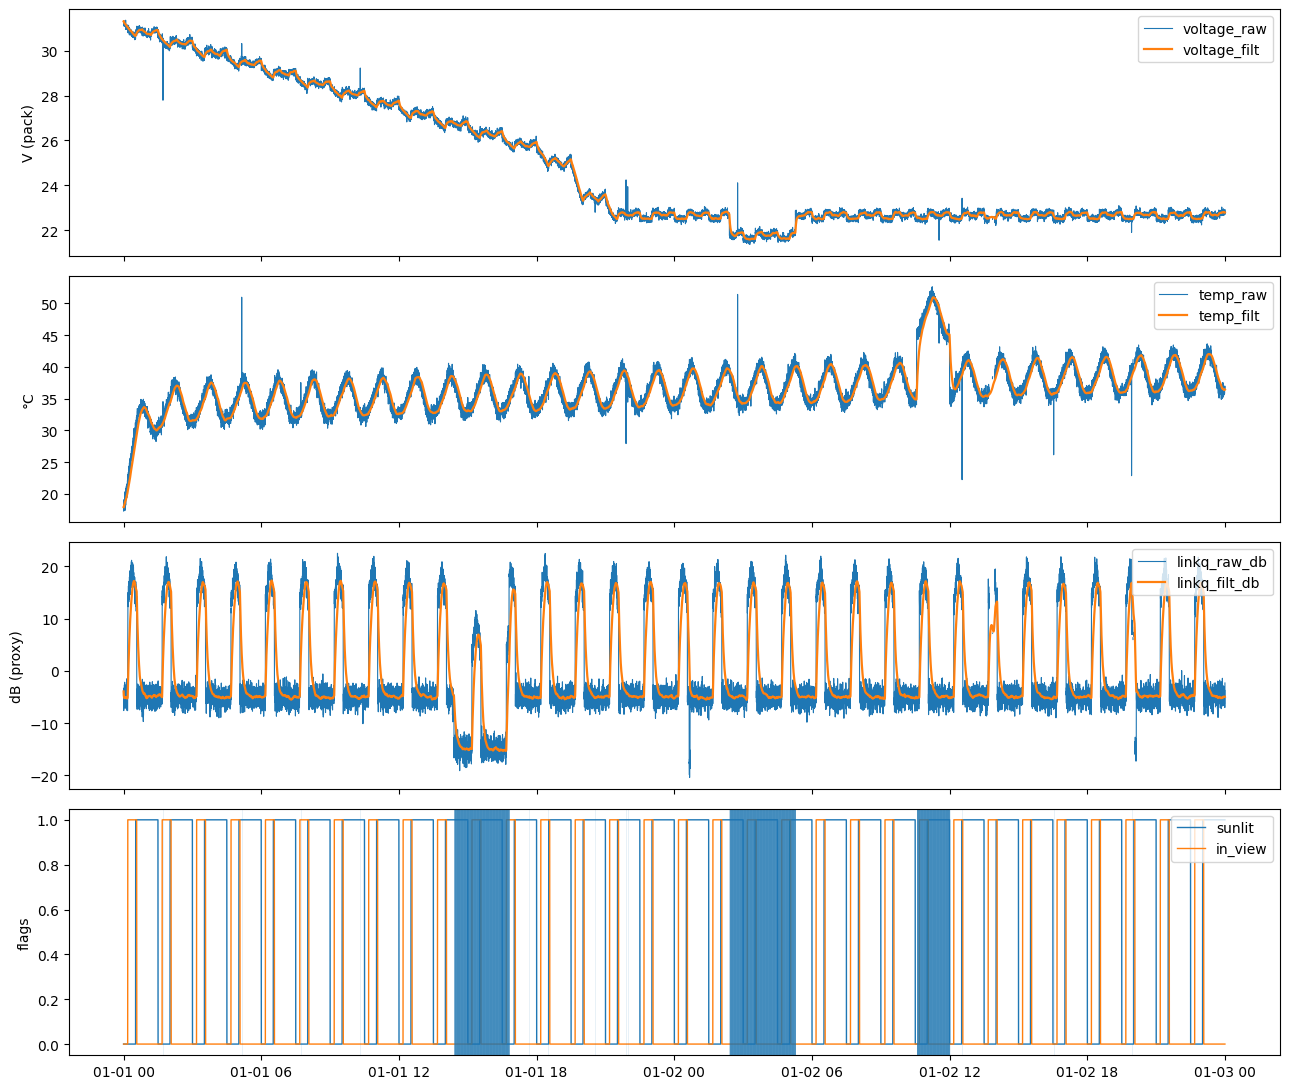

In [17]:
# ------------------------------------------------------------
# Main execution
# ------------------------------------------------------------
def main():
    # Dataset (48h at 10s resolution ~ 17280 samples)
    df = build_dataset(duration_hours=48.0, sample_period_s=10.0, seed=7)

    # Filtering
    df = filter_telemetry(df)

    # Detection
    df = rule_based_detection(df)

    # Set contamination near injected anomaly fraction for a fair synthetic benchmark
    injected_rate = df["label_gt"].mean()
    df = isolation_forest_detection(df, contamination=float(np.clip(injected_rate, 0.01, 0.25)), seed=7)

    # Evaluation:
    # 1) Full evaluation across all time (power/thermal faults exist regardless of in_view)
    full_eval = evaluate(df)

    # 2) In-view only evaluation (useful if your focus is downlink behavior)
    inview_eval = evaluate(df, mask=(df["in_view"] == 1))

    print("Evaluation vs ground truth (label_gt) — full timeline:")
    print("Rule-based:", full_eval["rule"])
    print("IsolationForest:", full_eval["iforest"])
    print(f"Evaluated samples: {full_eval['n_eval']} | GT anomaly rate: {full_eval['gt_rate']:.3f}")

    print("\nEvaluation vs ground truth (label_gt) — in_view only:")
    print("Rule-based:", inview_eval["rule"])
    print("IsolationForest:", inview_eval["iforest"])
    print(f"Evaluated samples: {inview_eval['n_eval']} | GT anomaly rate: {inview_eval['gt_rate']:.3f}")

    # Packet-loss statistics only during contact
    missed = (df["in_view"] == 1) & (df["comm_ok"] == 0)
    print("\nDownlink packet loss (only during in_view):")
    print(f"In-view samples: {int((df['in_view'] == 1).sum())}")
    print(f"Missed packets:  {int(missed.sum())} ({missed.mean():.2%} of all samples)")

    # Save results
    out_csv = "synthetic_satellite_telemetry.csv"
    df.to_csv(out_csv, index=True)
    print(f"\nSaved: {out_csv}")

    # Plot
    plot(df)


if __name__ == "__main__":
    main()
